# Corrective RAG - CRAG

* **Document Relevance Grading**: LLM evaluates wether the retrieved documents can aswer the question before generating a response <br>
* **Query Rewriting**: Automatically rewrites irrelevant with financial keywords and retries retrieval once <br>
* **Single Retry Cycle**: Prevents infinite loop by allowing one query rewrite and retrieval retry <br>
* **Cited Answer**: Generated markdown-formatted responses with inline citations and structured references

### 1. Imports

In [1]:
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain_chroma import Chroma
from langchain_core.tools import tool
from typing_extensions import TypedDict, Annotated
from dotenv import load_dotenv
from langchain_ollama import ChatOllama, OllamaEmbeddings
from pathlib import Path
from typing import Dict, List
from pydantic import BaseModel, Field
from scripts import my_tools
import os
load_dotenv()


True

### 2. Configurations

In [2]:
LLM_MODEL="qwen3:latest"
BASE_URL="http://localhost:11434"
EMBEDDING_MODEL="nomic-embed-text:latest"

llm = ChatOllama(
    model=LLM_MODEL,
    base_url=BASE_URL
)

### 3. Defining State

In [3]:
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]
    retrieved_docs: str
    is_relevant: bool
    rewritten_query: str

In [4]:
result = my_tools.web_search.invoke({"query":"Python Courses", "num_results": 3})

In [5]:
print(result)

Search results for search query: 'Python Courses'

1. **Online Python Courses for Beginners in Kerala**
   Notable online Python courses for beginners in Kerala include globally acclaimed options accessible anywhere, as well as Kerala-specific or India-focused programs. These courses cater to absolute beginners and often provide certificates, with some offering placement support or instruction in Malayalam.Key examples include:- "Programming for Everybody (Getting Started with Python)" on Coursera by the University of Michigan: Free to audit, beginner-friendly with no prerequisites, highly rated (98% approval), self-paced, and covers basics like data structures and functions.- Free Python courses from Great Learning ("Python Fundamentals for Beginners") and Entri App: 100% free, with certificate options, designed for absolute beginners.- ASAP Kerala's "Python for Data Management": A government-backed online course (400 hours, INR 16,000), starting from basics and advancing to data scie

In [6]:
result = my_tools.retriever_docs.invoke({"query": "Google's Revenue in 2023", "k": 2})

  [1] Doc 1: Score=1.9649
  [2] Doc 0: Score=1.1686
[RETRIEVED] 2 documents


In [7]:
print(result)

--- Document 1 ---
source_file: google 10-k 2023.pdf
file_hash: 1dceed8775b7b56432618aff917e08f9fe9573921f397a79b14bad5ab31e469a
fiscal_year: 2023
company_name: google
doc_type: 10-k
page: 100

Content:


## SUBSIDIARIES OF THE REGISTRANT

The following is a list of subsidiaries of Alphabet Inc., omitting subsidiaries which, considered in the aggregate as a single subsidiary, would not constitute a significant subsidiary as of December 31, 2023:

Name of Subsidiary Google LLC XXVI Holdings Inc. Alphabet Capital US LLC

Jurisdiction of Incorporation or Organization

Delaware

Delaware

Delaware


--- Document 2 ---
file_hash: 1dceed8775b7b56432618aff917e08f9fe9573921f397a79b14bad5ab31e469a
fiscal_year: 2023
page: 83
source_file: google 10-k 2023.pdf
doc_type: 10-k
company_name: google

Content:


|                                                                                               | Year Ended December 31, 2023   | Year Ended December 31, 2023   | Year Ended December 31, 2023 

## 4. Langgraph Nodes

### 4.1 Retriever Node

In [8]:
def retrieve_node(state: AgentState):
    print(f"[RETRIEVER NODE] fetching documents")
    
    user_question = state["messages"][-1].content
    print(f"[QUERY] User Query: {user_question}")

    result = my_tools.retriever_docs.invoke({"query": user_question, "k": 5})

    print("[RETRIEVER NODE] fetched relevant document")

    with open("debug_logs/crag_retrieved_docs.md", "w", encoding="utf-8") as f:
        f.write(f"Query: {user_question}\n\n")
        f.write(result)
    
    return {"retrieved_docs": result}

### 4.2 Document Grading Node

In [9]:
class GradeDescision(BaseModel):
    is_relevant: bool = Field(description="True if documents are relevant to answer the question, False if irrelevant")
    reasoning: str = Field(description="Brief Explanation of why documents are relevant or why are they irrelevant")

In [10]:
def grade_node(state: AgentState):
    llm_structured = llm.with_structured_output(GradeDescision)

    user_question = state['messages'][-1].content
    retrieved_docs = state.get('retrieved_docs', '')

    prompt = f"""You are a document relevance grader.

                    TASK: Evaluate if the retrieved documents are relevant to answer the user's question.

                    USER QUESTION: {user_question}

                    RETRIEVED DOCUMENTS:
                    {retrieved_docs}

                    GRADING CRITERIA:
                    - is_relevant = True: If documents contain information that can answer the question
                    - is_relevant = False: If documents are completely irrelevant or off-topic

                    Output JSON:
                    {{
                    "is_relevant": true/false,
                    "reasoning": "Brief explanation..."
                    }}"""
    
    response = llm_structured.invoke(prompt)

    print(f"[GRDAE] Relevance: {response.is_relevant}\nReasoning: {response.reasoning}")

    return {"is_relevant": response.is_relevant}



### 4.3 Rewrite Query and Retrieve from Internet Node

In [11]:
def rewrite_query_node(state: AgentState):
    user_question = state['messages'][-1].content

    prompt = f"""You are a query rewriting expert.

                TASK: Rewrite the user's question to make it more specific and targeted for document retrieval.

                ORIGINAL QUESTION: {user_question}

                INSTRUCTIONS:
                - Make the query more specific with keywords
                - Add relevant financial terms (revenue, profit, earnings, etc.)
                - Include company names, years, quarters if mentioned
                - Keep it concise (one sentence)

                Output ONLY the rewritten query, nothing else."""
    
    response = llm.invoke(prompt)
    rewritten_query = response.content.strip()

    print(f"[REWRITE] Original: {user_question}")
    print(f"[REWRITE] New: {rewritten_query}")

    return {"rewritten_query": rewritten_query}

### 4.4 Web Search Node

In [12]:
def web_search_node(state: AgentState):
    user_question = state['messages'][-1].content
    rewritten_query = state.get('rewritten_query', user_question)

    result = my_tools.web_search.invoke({"query": rewritten_query})

    with open("debug_logs/crag_retry_websearch_docs", "w", encoding="utf-8") as f:
        f.write(f"Rewritten Query: {rewritten_query}\n\n")
        f.write(result)
    
    return {"retrieved_docs": result}

### 4.5 Final Answer Node

In [13]:
def answer_node(state: AgentState):
    user_question = state['messages'][-1].content
    retrieved_docs = state.get('retrieved_docs', '')

    prompt = f"""You are an expert financial analyst.

            TASK: Provide a detailed answer to the user's question using the retrieved documents.

            REQUIREMENTS:
            1. Write 200-300 words
            2. Use MARKDOWN formatting:
            - ## Headings
            - **Bold** for key metrics
            - Bullet points for lists
            - Tables for comparisons
            3. Include inline citations [1], [2], [3]
            4. Add a References section at the end with format: "Company: x, Year: y, Quarter: z, Page: n"

            Be thorough and detailed. Use all relevant information from the documents.

            Here is the User Question: {user_question}

            Here is the Retrived Documents:
            {retrieved_docs}

            Provide the detailed answer with citation:
            """
    
    response = llm.invoke(prompt)

    return {"messages": [response]}

### 5. Router Logic

In [14]:
def should_rewrite(state: AgentState):
    is_relevant = state.get('is_relevant', True)

    if is_relevant:
        print(f"[ROUTER] Document is relevant, proceeding to answer")
        return "answer"
    else:
        print(f"[ROUTER] Document is not relevant, re-phrasing the query")
        return "rewrite"

### 6. Create CRAG Agent

In [15]:
def create_crag_agent():

    builder = StateGraph(AgentState)

    # add nodes
    builder.add_node('retriever', retrieve_node)
    builder.add_node('grade', grade_node)
    builder.add_node('rewrite', rewrite_query_node)
    builder.add_node('web_search', web_search_node)
    builder.add_node('answer', answer_node)

    # define edge
    builder.add_edge(START, 'retriever')
    builder.add_edge('retriever', 'grade')
    builder.add_conditional_edges('grade', should_rewrite, ['rewrite', 'answer'])

    builder.add_edge('rewrite', 'web_search')
    builder.add_edge('web_search', 'answer')

    builder.add_edge('answer', END)

    graph = builder.compile()

    return graph

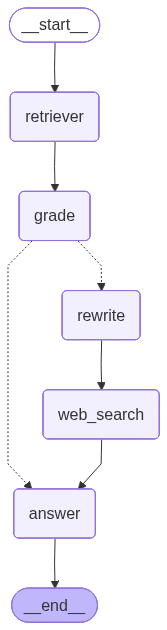

In [16]:
agent = create_crag_agent()
agent

### 7. Performance Test

In [18]:
query = "What is amazon's annual performance in 2024?"

result = agent.invoke({"messages": [HumanMessage(content=query)]})

[RETRIEVER NODE] fetching documents
[QUERY] User Query: What is amazon's annual performance in 2024?
  [1] Doc 0: Score=4.1450
  [2] Doc 2: Score=2.2364
  [3] Doc 1: Score=2.0805
[RETRIEVED] 3 documents
[RETRIEVER NODE] fetched relevant document
[GRDAE] Relevance: True
Reasoning: Document 1 contains specific 2024 financial performance data including AWS sales growth, operating expenses, cost of sales, and percentage changes compared to 2023, directly addressing the user's question about Amazon's annual performance in 2024. Documents 2 and 3 provide irrelevant information about accounting fees and executive leadership.
[ROUTER] Document is relevant, proceeding to answer


In [20]:
result

{'messages': [HumanMessage(content="What is amazon's annual performance in 2024?", additional_kwargs={}, response_metadata={}, id='ffac6b12-300b-4640-ad94-33172d5b1088'),
  AIMessage(content="## Amazon's Annual Performance in 2024  \n\nAmazon's 2024 fiscal year performance, detailed in its 10-K filing, highlights key financial trends and operational metrics. **AWS sales grew by 19% year-over-year**, driven by increased customer usage, though pricing changes from long-term contracts partially offset this growth [1]. Operating expenses rose to **$569.366 billion** in 2024, up from **$537.933 billion** in 2023, reflecting expanded operations and investments.  \n\n### **Operating Expense Breakdown**  \nThe following table compares 2023 and 2024 operating expenses (in millions):  \n\n| **Expense Category**               | **2023**      | **2024**      | **YoY Growth** | **% of Net Sales** |  \n|------------------------------------|---------------|---------------|----------------|-----------

In [23]:
result["messages"][-1].pretty_print()

================================== Ai Message ==================================

## Amazon's Annual Performance in 2024  

Amazon's 2024 fiscal year performance, detailed in its 10-K filing, highlights key financial trends and operational metrics. **AWS sales grew by 19% year-over-year**, driven by increased customer usage, though pricing changes from long-term contracts partially offset this growth [1]. Operating expenses rose to **$569.366 billion** in 2024, up from **$537.933 billion** in 2023, reflecting expanded operations and investments.  

### **Operating Expense Breakdown**  
The following table compares 2023 and 2024 operating expenses (in millions):  

| **Expense Category**               | **2023**      | **2024**      | **YoY Growth** | **% of Net Sales** |  
|------------------------------------|---------------|---------------|----------------|---------------------|  
| Cost of sales                      | $304,739      | $326,288      | **+7%**        | 53.0% → 51.1%   

In [24]:
query = "What is Google's, Amazon's, Tesla's annual financial report of 2024?, also draw a comparison table for all three and give me a short article based on that table"

result = agent.invoke({"messages": [HumanMessage(content=query)]})

result["messages"][-1].pretty_print()

[RETRIEVER NODE] fetching documents
[QUERY] User Query: What is Google's, Amazon's, Tesla's annual financial report of 2024?, also draw a comparison table for all three and give me a short article based on that table
  [1] Doc 0: Score=29.9306
  [2] Doc 2: Score=15.6797
  [3] Doc 1: Score=14.9919
[RETRIEVED] 3 documents
[RETRIEVER NODE] fetched relevant document
[GRDAE] Relevance: False
Reasoning: The retrieved documents only contain Google's 2024 financial information (10-K filing) and do not include Amazon's or Tesla's annual financial reports. The user explicitly requested data for all three companies, making the documents insufficient to fully answer the question.
[ROUTER] Document is not relevant, re-phrasing the query
[REWRITE] Original: What is Google's, Amazon's, Tesla's annual financial report of 2024?, also draw a comparison table for all three and give me a short article based on that table
[REWRITE] New: Retrieve the 2024 annual financial statements for Google, Amazon, and 